# Pyomo Homework 3

In [1]:
# Import the libraries you need here for the assignment
# Add your solution here
from pyomo.environ import *
from pyomo.dae import *
import casadi
import idaes
from pyomo.dae.simulator import Simulator
import scipy
import matplotlib.pyplot as plt

## Pyomo.DAE: Reaction Kinetics

Consider the chemical reaction $$A \Leftrightarrow B \Leftrightarrow C$$

which is modeling with the following differential algebraic equations:

$$\begin{align*}
\frac{dz_A}{dt} &= -p_1 z_A(t) + p_2 z_B(t),\quad z_A(0)=1 \\
\frac{dz_B}{dt} &= p_1 z_A(t) - (p_2 + p_3) z_B(t) + p_4 z_C(t), \quad z_B(0)=0 \\
1 &= z_A(t) + z_B(t) + z_C(t)
\end{align*}$$

where $p_1=4$, $p_2=2$, $p_3=40$, and $p_4=20$ are parameters with the appropriate units. $z_A(t)$, $z_B(t)$, and $z_C(t)$ are time varying concentrations of species $A$, $B$, and $C$ respectively.

### Index analysis

Determine the index of the above differential algebraic equation (DAE) system above.

Tip: do this on paper. On Gradescope, there will be a separate assignment for you to turn in your handwritten work.

### Model reformulation

Apply the index reduction algorithm from class as needed. Ultimately identify two versions of the model: one that is index 1 and another that is index 0. Find a consistent initial condition $z_C(0)$.

### Implement index 1 model in Pyomo

We will be building a library of functions.

#### Create model and set initial conditions

In [2]:
def create_model():
    ''' Create index 1 model and set initial conditions
    
    Return:
        m: Pyomo model
    '''
    
    # Tip: Set time to go from 0 to 1 when creating the model.
    
    m = ConcreteModel()

    m.t = ContinuousSet(bounds=(0.0, 1))
    
    # Add your solution here
    
    # Declare parameter - acceleration due to gravity
    m.p1 = Param(initialize = 4)
    m.p2 = Param(initialize = 2)
    m.p3 = Param(initialize = 40) 
    m.p4 = Param(initialize = 20) 
    
    # Declare variables indexed over time
    m.zA = Var(m.t) # concentration of A
    m.zB = Var(m.t) # concentration of B
    m.zC = Var(m.t) # concentration of C
    
    # Declare derivative variables
    m.dzA = DerivativeVar(m.zA)
    m.dzB = DerivativeVar(m.zB)
    
    # Declare differential equations
    def _dzA_eqn(m, t):
        return m.dzA[t] == -m.p1*m.zA[t] + m.p2*m.zB[t]
    m.dzA_eqn = Constraint(m.t, rule = _dzA_eqn)
    
    def _dzB_eqn(m, t):
        return m.dzB[t] == m.p1*m.zA[t] - (m.p2 + m.p3)*m.zB[t] + m.p4*m.zC[t]
    m.dzB_eqn = Constraint(m.t, rule = _dzB_eqn)
    
    # Declare algebraic equations
    def _alg_eqn(m, t):
        return m.zA[t] + m.zB[t] + m.zC[t] == 1
    m.alg_eqn1 = Constraint(m.t, rule=_alg_eqn)
    
    # Specify initial conditions
    m.zA[0] = 1
    m.zB[0] = 0
    #m.zC[0] = 0
    
    return m

### Simulate, discretize, and initialize collocation model

In [3]:
def simulate_discretize_model(m,NFE,initialize):
    ''' Simulation, discretize, and initialize the Pyomo model
    
    Arguments:
        m: Pyomo model
        NFE: number of finite elements to consider (integer)
        initialize: if True, initialize the discretized model with the 
             integrator solution (boolean)
    
    Returns:
        sim: Simulator object from Pyomo.DAE
        tsim: Timesteps returned from simulator
        profiles: Results returned from simulator
    
    Overall Steps:
    1. Create Pyomo.DAE simulator and integrate with casadi/idas
    2. Transform model using 'dae.collocation' strategy. Use 3 collocation points
        per finite elemebt
    3. If initialize is true, call 'sim.initialize_model()'. This will use the
        Simulator solution to initialize the discretized Pyomo model. Really cool!
    '''
    
    # Add your solution here
    
    # Create pyomo.DAE simulator
    sim = Simulator(m, package = 'casadi')
    # solve model
    tsim, profiles = sim.simulate(numpoints = 100, integrator='idas')
    
    # Discretize model
    discretizer = TransformationFactory('dae.collocation')
    discretizer.apply_to(m, nfe = NFE, ncp = 3)
    
    if initialize == True:
        # Initialize the discretized model using the simulator profiles
        sim.initialize_model()

    return sim, tsim, profiles

### Plot results

In [4]:
def plot_result(m, sim, tsim, profiles, include_model_values):
    """ Plot the results from the simulator (and optionally Pyomo model)
    
    Arguments:
        m: Pyomo model
        sim: Pyomo.DAE simulator
        tsim: timesteps from simulator
        profiles: results from simulation
        include_model_values: if True, also plot the values from the Pyomo model m
    
    Returns:
        nothing
        
    Actions/Steps/Tips:
    1. Plot the results stored in tsim and profiles as solid lines. Recycle code from class.
    2. If 'include_model_values' is true, plot za, zb, and zc values stored in Pyomo model 'm'.
        Use a solid symbol.
    3. Add a legend and axes labels
    """
    
    # Add your solution here
    plt.figure(1)
    varorder = sim.get_variable_order()
    algorder = sim.get_variable_order(vartype='algebraic')

    # Create empty dictionary
    results = {}
    
    for idx1, v in enumerate(varorder):
        i = idx1
        v_ = str(v)
        results[v_] = profiles[:, i]
        plt.plot(tsim, results[v_], label = v)

    for idx2, v in enumerate(algorder):
        i = len(varorder) + idx2
        v_ = str(v)
        results[v_] = profiles[:, i]
        plt.plot(tsim, results[v_], label = v)
    
    plt.xlabel('time, t')
    plt.ylabel('concentration, z')
    
    
    if include_model_values == True:
        zA = [value(m.zA[t]) for t in m.t]
        zB = [value(m.zB[t]) for t in m.t]
        zC = [value(m.zC[t]) for t in m.t]
        plt.plot(m.t, zA,'tab:blue', marker='o', label = 'model zA')
        plt.plot(m.t, zB,'tab:orange', marker='o',label = 'model zB')
        plt.plot(m.t, zC,'tab:green', marker='o',label = 'model zC')
        
    plt.legend(loc='best')
    plt.show()
    # Tip: Do not forget to include `plt.show()` (assuming you imported matplotlib.pyplot as plt)

In [5]:
def solve_model(m):
    """ Solve discretized model with Ipopt
    
    Arguments:
        m: Pyomo model
        
    Returns:
        nothing
    """
    
    # Specify initial conditions
    def _init(m):
        yield m.zA[0] == 1
        yield m.zB[0] == 0
    model.initcon = ConstraintList(rule = _init)

    # Solve collocation formulation (no objective, we are just simulating)
    solver = SolverFactory('ipopt')
    solver.solve(model,tee=True)

### Simulate and solve Pyomo model with initialization

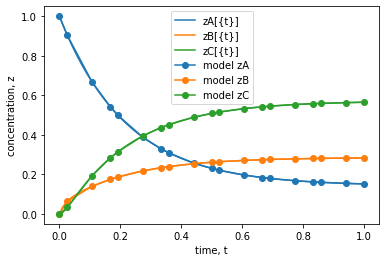

In [6]:
# Create Pyomo model
model = create_model()

# Initialize discretized model with simulation result?
init = True

# Number of finite elements
NFE = 6

# Simulate model
sim, tsim, profiles = simulate_discretize_model(model,NFE,init)

# Plot simulation results
plot_result(model, sim, tsim, profiles, True)

Ipopt 3.13.3: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      372
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       95
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total 

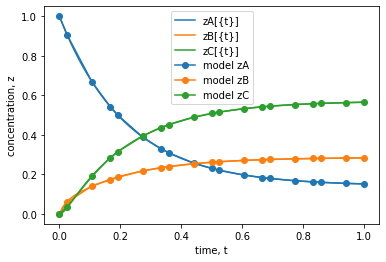

In [7]:
# Solve collocation formulation with Ipopt
solve_model(model)

# Plot results
plot_result(model, sim, tsim, profiles, True)

### Simulate and solve Pyomo model without initialization

Repeat the analysis from above, but do NOT initialize the discretized model with the simulation result. (Tip: you only need to change two small things.)

In [8]:
# Add your solution here
# Create Pyomo model
model = create_model()

# Initialize discretized model with simulation result?
init = False

# Number of finite elements
NFE = 6

# Simulate model
sim, tsim, profiles = simulate_discretize_model(model,NFE,init)

Ipopt 3.13.3: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      372
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       95
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total 

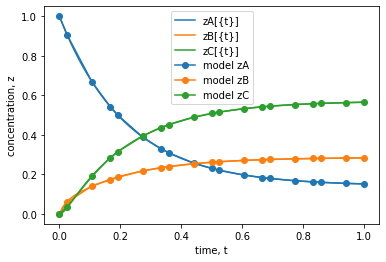

In [9]:
# Solve collocation formulation with Ipopt
solve_model(model)

# Plot results
plot_result(model, sim, tsim, profiles, True)

### Discussion: Does initialization matter?

Write 1 to 3 sentences for each of the following questions:

*What happens if we disable initialization? Does the number of interactions Ipopt need change?*

When we disable initialization neither the solution nor the number of iterations change.

*Why is this specific problem robust to poor initialization? What about this specific DAE system makes it easy to solve?*

This is an index one DAE so it is easier to solve.

### Degree of Freedom Analysis

Please answer on paper and turn in via Gradescope.

Rerun the code above for two different numbers of finite elements. Record the total number of variables and equality constraints.

How many degrees of freedom are in the simulation problem? (1 sentence is fine.)

Choose $N=3$ or a simular number of finite elements. Using the collocation equations from class, show that the discretized Pyomo model has the correct number of variables and algebraic equations. This will be a little tedious, but good to practice once on a simple model. You might need to do this when debugging a DAE model for research.

Note: You might get a strange answer. That is okay.

Ipopt 3.13.3: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      612
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      155
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total 

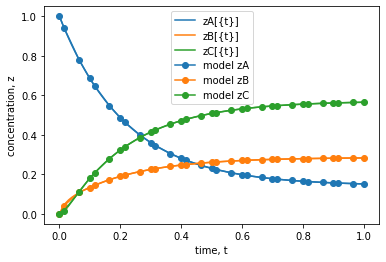

In [10]:
# Add your solution here
# Create Pyomo model
model = create_model()

# Initialize discretized model with simulation result?
init = False

# Number of finite elements
NFE = 10

# Simulate model
sim, tsim, profiles = simulate_discretize_model(model, NFE, init)

# Solve collocation formulation with Ipopt
solve_model(model)

# Plot results
plot_result(model, sim, tsim, profiles, True)

Ipopt 3.13.3: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      312
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       80
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total 

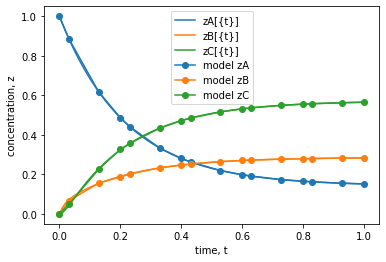

In [11]:
# Add your solution here
# Create Pyomo model
model = create_model()

# Initialize discretized model with simulation result?
init = False

# Number of finite elements
NFE = 5

# Simulate model
sim, tsim, profiles = simulate_discretize_model(model, NFE, init)

# Solve collocation formulation with Ipopt
solve_model(model)

# Plot results
plot_result(model, sim, tsim, profiles, True)